# Tarea 2

Integrantes:
* Juan José Maulén 
* Pedro Pérez
* Tomás Rojas

In [ ]:
#P1

In [10]:
from torchvision.datasets import DatasetFolder
import torch
import random
from PIL import Image
import numpy as np
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler, RandomSampler

In [11]:
def random_rotation(im, theta):
    theta = random.uniform(*theta)
    return im.rotate(theta)

def random_flip(im):
    if bool(random.getrandbits(1)):
        im = im.transpose(Image.FLIP_LEFT_RIGHT)
    return im
    
def loader(path):
    transformation = ToTensor()
    
    im = Image.open(path).resize((224, 224))  # escalamiento de la imagen
    im = random_flip(im)  # reflexion de la imagen
    im = random_rotation(im, (-20, 20))  # rotacion aleatoria de la imagen
    
    
    tensor = transformation(im)  # se transforma la imagen a un tensor
    if tensor.shape[0] == 1:
        tensor = tensor.repeat(3, 1, 1)
    
    rand_tensor = (1.5 - 1.2) * torch.rand((3, 224, 224)) + 1.2
    return tensor * rand_tensor


In [ ]:
im = Image.open('./chest_xray/test/NORMAL/IM-0001-0001.jpeg')
%timeit im.transpose(Image.FLIP_LEFT_RIGHT)
%timeit np.fliplr(im)

In [ ]:
from skimage.transform import rotate as sk_rotation
%timeit im.rotate(20)
im_asarray = np.array(im)
%timeit sk_rotation(im_asarray, 20)

In [ ]:
xrays = glob.glob('./chest_xray/test/PNEUMONIA/*.jpeg')

In [ ]:
def plot_xrays(n, paths, *args, **kwargs):
    im2use = random.choices(paths, k=n)
    fig, ax = plt.subplots(2, n, *args, **kwargs)
    fig.tight_layout(h_pad=-20.0*n/3)
    for i, path in enumerate(im2use):
        ax[0, i].imshow(Image.open(path), 'gray')
        ax[0, i].set_title('Imagen {} original'.format(i + 1))
    for i, path in enumerate(im2use):
        ax[1, i].imshow(loader(path).sum(axis=0), 'gray')
        ax[1, i].set_title('Imagen {} al cargar'.format(i + 1))
    return

In [ ]:
plot_xrays(3, xrays, figsize=(10,10))

In [ ]:
train_folder = DatasetFolder('./chest_xray/train', loader=loader, extensions='.jpeg')
# distribución real
test_folder = DatasetFolder('./chest_xray/test', loader=loader, extensions='.jpeg')

In [ ]:
def histogram(train_folder, test_folder):
    train_folder_x, train_folder_y = np.unique(train_folder.targets, return_counts=True)
    test_folder_x, test_folder_y = np.unique(test_folder.targets, return_counts=True)
    plt.figure(figsize=(10,5))
    plt.bar(["'NORMAL' train","'PNEUMONIA' train"], 
            train_folder_y)
    plt.bar(["'NORMAL' test","'PNEUMONIA' test"], 
            test_folder_y)

    p_normal_train = train_folder_y[0] / train_folder_y.sum()
    p_pneumonia_train = train_folder_y[1] / train_folder_y.sum()
    p_normal_test = test_folder_y[0] / test_folder_y.sum()
    p_pneumonia_test = test_folder_y[1] / test_folder_y.sum()


    plt.text(-.1, train_folder_y[0] + 15,
             '{:.2f}%'.format(p_normal_train * 100))

    plt.text(-.1 + 1, train_folder_y[1] + 15,
             '{:.2f}%'.format(p_pneumonia_train * 100))

    plt.text(-.1 + 2, test_folder_y[0] + 15,
             '{:.2f}%'.format(p_normal_test * 100))

    plt.text(-.1 + 3, test_folder_y[1] + 15,
             '{:.2f}%'.format(p_pneumonia_test * 100))
    return

In [ ]:
histogram(train_folder, test_folder)

In [ ]:
# train test split
n_test =  int(len(train_folder) * .2)  
n_train = len(train_folder) - n_test
conjunto_train, conjunto_val = torch.utils.data.random_split(train_folder, [n_train, n_test])

In [ ]:
class ReplicarMuestreoDePrueba(torch.utils.data.Sampler):
    
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        if len(etiquetas_val) != len(indices_val):
            etiquetas_val = np.array(etiquetas_val)[indices_val]
        self.etiquetas_prueba = np.array(etiquetas_prueba)
        self.indices_val = np.array(indices_val)
        self.etiquetas_val = np.array(etiquetas_val)
        
    def __iter__(self):
        # {'NORMAL': 0, 'PNEUMONIA': 1}
        clases_prueba, frecuencias_prueba = np.unique(self.etiquetas_prueba, 
                                                      return_counts=True)
        
        p_normal_deseada = frecuencias_prueba[0] / frecuencias_prueba.sum()
        
        indices_val_0 = self.indices_val[np.where(np.array(self.etiquetas_val)==0)]
        indices_val_1 = self.indices_val[np.where(np.array(self.etiquetas_val)==1)]
        
        n_1 = len(indices_val_1)
        n_0 = int(n_1 *p_normal_deseada/(1 - p_normal_deseada))
        
        indices_val_0 = np.random.choice(indices_val_0, n_0)
        
        lista_con_indices = indices_val_0.tolist() + indices_val_1.tolist()
        return iter(lista_con_indices)

In [ ]:
val_sampler = ReplicarMuestreoDePrueba(test_folder.targets, 
                                        conjunto_val.indices, 
                                        conjunto_val.dataset.targets)
bs = 4
training_sampler = SubsetRandomSampler(conjunto_train.indices)
test_sampler = RandomSampler(range(len(test_folder)))
train_dl = DataLoader(train_folder, batch_size = bs, sampler = training_sampler)
validation_dl = DataLoader(train_folder, batch_size = bs, sampler = val_sampler)
test_dl = DataLoader(test_folder, batch_size = bs, sampler = test_sampler)

In [ ]:
# P2

In [12]:
import torch

torch.manual_seed(4020)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class DWSepConv2d(nn.Module):
    
    def __init__(self,  in_channels, out_channels, kernel_size, padding, bias=True):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, padding, bias = bias)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias = bias)
        
    def forward(self, x):
        xb = self.conv1(x)
        xb = F.relu(self.conv2(xb))
        return xb

In [14]:
class VGG16DWSep(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1layer1=nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.conv1layer2=nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.maxpool2d1=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2layer1=DWSepConv2d(64,128,3,1)
        self.conv2layer2=DWSepConv2d(128,128,3,1)
        self.maxpool2d2=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv1=DWSepConv2d(128,256,3,1)
        self.batchnorm1=nn.BatchNorm2d(256)
        
        self.conv2=DWSepConv2d(256,256,3,1)
        self.batchnorm2=nn.BatchNorm2d(256)
        
        self.conv3=DWSepConv2d(256,512,3,1)
        self.maxpool2d3=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv4=DWSepConv2d(512,512,3,1)
        self.batchnorm4=nn.BatchNorm2d(512)
        
        self.conv5=DWSepConv2d(512,512,3,1)
        self.batchnorm5=nn.BatchNorm2d(512)
        
        self.conv6=DWSepConv2d(512,512,3,1)
        self.maxpool2d6=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.flatten=nn.Flatten()
        
        self.fc1 = nn.Linear(512*81, 1024)
        self.dropout1=nn.Dropout(.7)
        
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2=nn.Dropout(.5)
        
        self.fc3 = nn.Linear(512, 2)
    
       
    def forward(self,xb):
        xb = xb.view(-1,3,224,224)
        xb = F.relu(self.conv1layer1(xb))
        xb = F.relu(self.conv1layer2(xb))
        xb = F.relu(self.maxpool2d1(xb))
        
        xb = F.relu(self.conv2layer1(xb))
        xb = F.relu(self.conv2layer2(xb))
        xb = F.relu(self.maxpool2d2(xb))
        
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.batchnorm1(xb))
        
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.batchnorm2(xb))
        
        xb = F.relu(self.conv3(xb))
        xb = F.relu(self.maxpool2d3(xb))
        
        xb = F.relu(self.conv4(xb))
        xb = F.relu(self.batchnorm4(xb))
        
        xb = F.relu(self.conv5(xb))
        xb = F.relu(self.batchnorm5(xb))
        
        xb = F.relu(self.conv6(xb))
        xb = F.relu(self.maxpool2d6(xb))
        
        xb = F.relu(self.flatten(xb))
        
        xb = F.relu(self.fc1(xb))
        xb = F.relu(self.dropout1(xb))
        
        xb = F.relu(self.fc2(xb))
        xb = F.relu(self.dropout2(xb))
        
        xb = F.relu(self.fc3(xb))
        
        return xb.view(-1, xb.size(1))

In [15]:
#Capas preentrenadas
import torchvision
from torchvision import models


model_VGG16 = torchvision.models.vgg16(pretrained=True, progress=True)
pesos_capa1 = model_VGG16.features[0].weight
pesos_capa2 = model_VGG16.features[2].weight
pesos_capa1.requires_grad = False
pesos_capa2.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\Rocio/.cache\torch\checkpoints\vgg16-397923af.pth


In [16]:
class VGG16DWSep(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1layer1=nn.Conv2d(3,64,kernel_size=3,padding=1)
        self.conv1layer1.weight = pesos_capa1
        self.conv1layer2=nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.conv1layer2.weight = pesos_capa2
        self.maxpool2d1=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2layer1=DWSepConv2d(64,128,3,1)
        self.conv2layer2=DWSepConv2d(128,128,3,1)
        self.maxpool2d2=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv1=DWSepConv2d(128,256,3,1)
        self.batchnorm1=nn.BatchNorm2d(256)
        
        self.conv2=DWSepConv2d(256,256,3,1)
        self.batchnorm2=nn.BatchNorm2d(256)
        
        self.conv3=DWSepConv2d(256,512,3,1)
        self.maxpool2d3=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv4=DWSepConv2d(512,512,3,1)
        self.batchnorm4=nn.BatchNorm2d(512)
        
        self.conv5=DWSepConv2d(512,512,3,1)
        self.batchnorm5=nn.BatchNorm2d(512)
        
        self.conv6=DWSepConv2d(512,512,3,1)
        self.maxpool2d6=nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.flatten=nn.Flatten()
        
        self.fc1 = nn.Linear(512*81, 1024)
        self.dropout1=nn.Dropout(.7)
        
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2=nn.Dropout(.5)
        
        self.fc3 = nn.Linear(512, 2)
    
       
    def forward(self,xb):
        xb = xb.view(-1,3,224,224)
        xb = F.relu(self.conv1layer1(xb))
        xb = F.relu(self.conv1layer2(xb))
        xb = F.relu(self.maxpool2d1(xb))
        
        xb = F.relu(self.conv2layer1(xb))
        xb = F.relu(self.conv2layer2(xb))
        xb = F.relu(self.maxpool2d2(xb))
        
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.batchnorm1(xb))
        
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.batchnorm2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.relu(self.maxpool2d3(xb))
        
        xb = F.relu(self.conv4(xb))
        xb = F.relu(self.batchnorm4(xb))
        
        xb = F.relu(self.conv5(xb))
        xb = F.relu(self.batchnorm5(xb))
        
        xb = F.relu(self.conv6(xb))
        xb = F.relu(self.maxpool2d6(xb))
        
        xb = F.relu(self.flatten(xb))
        
        xb = F.relu(self.fc1(xb))
        xb = F.relu(self.dropout1(xb))
        
        xb = F.relu(self.fc2(xb))
        xb = F.relu(self.dropout2(xb))
        
        xb = F.relu(self.fc3(xb))
        
        return xb.view(-1, xb.size(1))

In [17]:
class EarlyStopping():
    
    def __init__(self, modo='min', paciencia=5, porcentaje=False, tol=0):
        self.modo = modo
        self.wait = paciencia
        self.perc = porcentaje
        self.tol = tol
        self.best = None
        self.bestep = 0
    
    def mejor(self, metrica_validacion):
        
        '''
        Retorna True cuando se mejora el mejor valor obtenido en métrica. 
        En caso contrario retorna False.
        '''
        
        if self.best == None:
            self.best = metrica_validacion
            return True
        if self.perc == False:
            if self.modo == 'min':
                if metrica_validacion < self.best - self.tol:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
            else:
                if metrica_validacion > self.best + self.tol:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
        else: 
            if self.modo == 'min':
                if metrica_validacion < (1-self.tol)*self.best:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
            else:
                if metrica_validacion > (1+self.tol)*self.best:
                    self.best = metrica_validacion
                    self.bestep = 0
                    return True
                else:
                    self.bestep += 1
                    return False
        
    
    def deberia_parar(self, metrica_validacion):
        comp = self.mejor(metrica_validacion)
        if not comp and self.bestep == self.wait:
            return True
        else:
            return False

In [ ]:
torch.cuda.is_available()

In [ ]:
torch.device("cuda") 

In [ ]:
#Ciclo de entrenamiento
from torch import optim
from sklearn.metrics import f1_score

f1 = []
acurracy = []
losses = []
model = VGG16DWSep()
model.cuda()
opt = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_func = F.cross_entropy
num_epoch = 20
es  = EarlyStopping(modo = 'max')
for epoch in range(num_epoch):
    #ciclo de entrenamiento
    for i, (images, labels) in enumerate(train_dl):
        
        outputs = model(images.cuda())
        loss = loss_func(outputs.cuda(), labels.long().cuda())
        losses.append(loss.item())

        loss.backward()
        opt.step()
        opt.zero_grad()
        
    #ciclo de validación
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(validation_dl):
        outputs = model(images.cuda()) 
        correct += (torch.argmax(outputs, dim=1) == labels.cuda()).float().sum() 
        total += len(labels)
    
    metrica_validacion_1 = 100 * correct / total #acurracy
    metrica_validacion_1 = metrica_validacion_1.item()
    #metrica_validacion_2 = f1_score(labels.detach().cpu().numpy(), outputs.detach().cpu().numpy())
    if (epoch+1) % 2 == 0:
        print('Epoca:', epoch+1,',', 'metrica:', metrica_validacion_1)
    acurracy.append(metrica_validacion_1)
    #f1.append(metrica_validacion_2)
    if es.deberia_parar(metrica_validacion_1):
        break
    

In [ ]:
acurracy

In [ ]:
#ciclo de testeo del modelo
for i, (images, labels) in enumerate(test_dl):
    outputs = model(images.cuda()) 
    correct += (torch.argmax(outputs, dim=1) == labels.cuda()).float().sum() 
    total += len(labels)
    valor = 100 * correct / total #acurracy
    valor = valor.item()
valor

In [ ]:
import pickle

f = open('tarea2_model', 'wb')
pickle.dump(model, f)
f.close()

In [ ]:
#P3

In [38]:
from PIL import Image
import numpy as np
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
#Se importa la imagen y se le hacen las transformaciones correspondientes


transform = transforms.Compose([transforms.Resize(299),
                                transforms.CenterCrop(299),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])])

img=Image.open('P3_example.jpg').convert('RGB') 
img_t=transform(img)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Imagen original')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('Imagen transformada')
plt.imshow(transforms.ToPILImage()(img_t))
plt.show()

In [ ]:
from keras.applications.imagenet_utils import decode_predictions
from torchvision import models
import torch

#Se carga y entrena la red Inception V3

model = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
model.eval()


In [ ]:
#Se hacen las predicciones para la imagen de control
#Se imprimen las diez primeras predicciones y se grafican los puntajes de los 
#5 primeros

input_batch = img_t.unsqueeze(0) 


if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
      preds = model(input_batch)


print('Predicted:', decode_predictions(preds.cpu().detach().numpy(), top=10))


labels=[]
scores=np.zeros(5)
for i in range(5):
    labels.append(decode_predictions(preds.cpu().detach().numpy(), top=10)[0][i][1])
    scores[i]=decode_predictions(preds.cpu().detach().numpy(), top=10)[0][i][2]

plt.bar(range(5), scores, edgecolor='black')

plt.xticks(range(5), labels, rotation=60)
plt.title("Puntajes obtenidos por las 5 clases más probables")
plt.show()

In [ ]:
from skimage.segmentation import slic
#Crea el slic pedido, arreglo 299 x 299
slic_1=slic(transforms.ToPILImage()(img_t),n_segments=80)
n_cat=np.amax(slic_1)  + 1 #Parten desde la categoria 0


In [ ]:
from skimage.segmentation import slic
from skimage import segmentation
#Visualizacion del Slic

slic = slic(img, n_segments=80)

plt.figure
plt.imshow(segmentation.mark_boundaries(img, slic))
plt.title('Visualización de super-pixeles')

plt.show()

In [ ]:
#Crear perturbaciones

n_pert=1000

perturbaciones={} #Diccionario con las perturbaciones

for i in range (n_pert):
    perturbaciones[i]=np.random.binomial(size=n_cat, n=1, p= 0.5)



In [ ]:
#Se crean las imagenes perturbadas, se guardan en el diccionario imgs_pert


imgs_pert={}
img_t_copy=img_t.detach().numpy()


#Para cada perturbacion, se le agrega una nueva capa a la imagen de control. 
#Esta nueva capa tiene el arreglo con los clusters, y en el caso que el cluster
#correspondiente tenga un 0 en la perturbación, se reemplaza el valor por un 999.
#En la imagen de control, si la nueva capa tiene un 999, se reemplazan todos los pixeles
#correspondientes por un 0.


for i in range(n_pert):
    aux=np.copy(slic_1)
    pert=perturbaciones[i]
    for j in range(n_cat):
        if pert[j]==0:
            aux[aux==j]=999
    img_pert=np.zeros((4,299,299))
    img_pert[0,:,:]=aux
    img_pert[[1,2,3],:,:]=img_t_copy
    img_pert[1][img_pert[0]==999]=0
    img_pert[2][img_pert[0]==999]=0
    img_pert[3][img_pert[0]==999]=0
    imgs_pert[i]=torch.tensor(img_pert[[1,2,3]],dtype=torch.float32)
      


In [ ]:
#Se muestran 3 imagenes perturbadas


fig, axs = plt.subplots(1, 3, figsize=(10, 3))
plt.suptitle('Visualización de imágenes perturbadas ',fontsize=20,x=0.5, y=1.05)
for ax, i in zip(axs, np.random.randint(1,1000,3)):
    ax.imshow(transforms.ToPILImage()(imgs_pert[i]))
    ax.grid(True)

plt.show()


In [ ]:
#Se hacen las predicciones usando InceptionV3 para cada imagen perturbada, 
#y se forma el arreglo y, con un 1 si se clasifico como "labrador_retriever"
#y 0 si no

y=np.zeros(n_pert)
clas_expected=labels[0]


for i in range(n_pert):
    input_batch=torch.unsqueeze(imgs_pert[i],0)
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        preds = model(input_batch)


    clas=decode_predictions(preds.cpu().detach().numpy())[0][0][1]
    if clas== clas_expected:
        y[i]=1


In [ ]:
#Se calcula la distancia coseno y los pesos asociados a cada vector de perturbaciones vs. 
#el vector de perturbacion de la imagen de control (un vector de 1s)
from numpy import linalg as LA

sigma=0.25
dist=np.zeros(n_pert)

for i in range(n_pert):
    dist[i]=1 - np.dot(perturbaciones[i],np.ones(n_cat))/(LA.norm(perturbaciones[i])*LA.norm(np.ones(n_cat)))

pi=np.exp(-np.square(dist)/sigma**2)


In [ ]:
#Se genera el conjunto de entrenamiento y se hace la regresion logistica
from sklearn.linear_model import LogisticRegression

D_p = np.zeros((n_pert,n_cat))

for i in range(n_pert):
    D_p[i]=perturbaciones[i]

clf = LogisticRegression()
clf.fit(D_p,y,sample_weight=pi)

In [ ]:
#Se obtienen los coeficientes del clasificador anterior
coef=np.std(D_p, 0)*clf.coef_

coef=coef.flatten()

#Se obtienen los 10 coeficientes con mayor valor
n=10
idx = (-coef).argsort()[:n]
#coef[idx]

plt.bar(range(n), coef[idx], edgecolor='black')
plt.xticks(range(n), idx, rotation=60)
plt.title("10 mayores coeficientes para superpixeles")
plt.show()

In [ ]:
#Se genera una visualización de la imagen considerando solo los superpixeles 
#más importantes, encontrados en el paso anterior
img_t_copy=img_t.detach().numpy()
aux=np.copy(slic_1)

for i in range(n):
    aux[aux==idx[i]]=999

img_new=np.zeros((4,299,299))
img_new[0,:,:]=aux
img_new[[1,2,3],:,:]=img_t_copy
img_new[1][img_new[0] != 999]=0
img_new[2][img_new[0] != 999]=0
img_new[3][img_new[0] != 999]=0

img_new=torch.tensor(img_new[[1,2,3]],dtype=torch.float32)

plt.figure()
plt.imshow(transforms.ToPILImage()(img_new))
plt.title('10 superpixeles más importantes usando SLIC')
plt.show()


In [ ]:
#Para hacer la clusterización, necesitamos la imagen en escala de grises



img_gray=transforms.Resize(299)(img)
img_gray=transforms.CenterCrop(299)(img_gray)
img_gray = np.mean(np.asarray(img_gray), axis=2, dtype=np.int32) #Se pasa a grises
img_gray = transforms.ToPILImage()(img_gray) 

plt.figure()
plt.imshow(img_gray, cmap="Greys_r")
plt.show()


In [ ]:
#Se genera la matriz de entrenamiento, tiene 299*299 filas. 
#Cada fila tiene un arreglo de 3 dimensiones, donde la primera y la segunda
#representan la fila y columna de un pixel de la representación matricial de 
#la imagen, y la tercera es la intensidad de la escala de grises.


X_train=np.zeros((299*299,3))

for i in range(299):
    for j in range(299):
        row=np.zeros(3)
        row=([i , j, np.asarray(img_gray)[i][j] ])
        X_train[i*299 + j]=row


In [ ]:
from sklearn.cluster import MiniBatchKMeans

#Clusterizaremos la matriz usando MiniBatchKMeans

MiniBatchKMeans = MiniBatchKMeans(n_clusters=40,random_state=20).fit(X_train)

In [ ]:
MiniBatchKMeans_matrix=MiniBatchKMeans.labels_.reshape((299,299))

In [ ]:
from sklearn.mixture import GaussianMixture

#Se clusteriza usando GaussianMixture

Gaussian = GaussianMixture(n_components=40, random_state=20).fit(X_train)

In [ ]:
Gaussian_matrix = Gaussian.predict(X_train).reshape(299,299)

In [50]:
#Se replica el esquema LIME anterior, pero cambiando la matrix slic_1 
#usada anteriormente por las matrices nuevas después de Clusterizar
from numpy import linalg as LA
from sklearn.linear_model import LogisticRegression

img_t_copy=img_t.detach().numpy()
clas_expected=labels[0]

def Lime(n_pert,matrix,cluster_method, net='InceptionV3', sigma=0.25, n_top=10):
  
    '''
        Dada la matriz con la segmentación en super-pixeles, se emplea el algoritmo LIME
        detallado anteriormente para generar una visualización de la imagen mostrando los
        super-pixeles más importantes.
        '''
        

    
    if net=='InceptionV3':
        clas_expected=labels[0]
    else: 
        clas_expected=torch.tensor(1)
        model=torch.load('./model.h5', map_location=torch.device('cpu'))
        
    
    
    imgs_pert={}

    n_cat=np.amax(matrix)+1
    perturbaciones={} #Diccionario con las perturbaciones

    for i in range (n_pert):
        perturbaciones[i]=np.random.binomial(size=n_cat, n=1, p= 0.5)


  
    for i in range(n_pert):
        aux=np.copy(matrix)
        pert=perturbaciones[i]
        for j in range(n_cat):
            if pert[j]==0:
                aux[aux==j]=999
        img_pert=np.zeros((4,img_t_copy.shape[1],img_t_copy.shape[1]))
        img_pert[0,:,:]=aux
        img_pert[[1,2,3],:,:]=img_t_copy
        img_pert[1][img_pert[0]==999]=0
        img_pert[2][img_pert[0]==999]=0
        img_pert[3][img_pert[0]==999]=0
        imgs_pert[i]=torch.tensor(img_pert[[1,2,3]],dtype=torch.float32)

    y=np.zeros(n_pert)
    
    if net=='InceptionV3':
    
        for i in range(n_pert):
            input_batch=torch.unsqueeze(imgs_pert[i],0)
            if torch.cuda.is_available():
                input_batch = input_batch.to('cuda')
                model.to('cuda')

            with torch.no_grad():
                preds = model(input_batch)


            clas=decode_predictions(preds.cpu().detach().numpy())[0][0][1]
            if clas== clas_expected:
                y[i]=1
    else: 
        for i in range(n_pert):
            output = model(imgs_pert[i])
            preds = torch.argmax(output)
            if preds== clas_expected:
                    y[i]=1
  
    dist=np.zeros(n_pert)

    for i in range(n_pert):
        dist[i]=1 - np.dot(perturbaciones[i],np.ones(n_cat))/(LA.norm(perturbaciones[i])*LA.norm(np.ones(n_cat)))

    pi=np.exp(-np.square(dist)/sigma**2)

    D_p = np.zeros((n_pert,n_cat))

    for i in range(n_pert):
        D_p[i]=perturbaciones[i]

    clf = LogisticRegression()
    clf.fit(D_p,y,sample_weight=pi)

    coef=np.std(D_p, 0)*clf.coef_
    coef=coef.flatten()

 
    idx = (-coef).argsort()[:n_top]

    aux=np.copy(matrix)

    for i in range(n_top):
        aux[aux==idx[i]]=999

    img_new=np.zeros((4,img_t_copy.shape[1],img_t_copy.shape[1]))
    img_new[0,:,:]=aux
    img_new[[1,2,3],:,:]=img_t_copy
    img_new[1][img_new[0] != 999]=0
    img_new[2][img_new[0] != 999]=0
    img_new[3][img_new[0] != 999]=0

    img_new=torch.tensor(img_new[[1,2,3]],dtype=torch.float32)

    plt.figure()
    plt.imshow(transforms.ToPILImage()(img_new))
    plt.title(str(n_top)+' superpixeles más importantes usando '+cluster_method)
    plt.show()

In [ ]:
Lime(1000,MiniBatchKMeans_matrix,'MiniBatchKMeans')

In [ ]:
Lime(1000,Gaussian_matrix,'Gaussian Mixture')

In [18]:
#'./chest_xray/test/PNEUMONIA/*.jpeg'

model = torch.load('./model.h5', map_location=torch.device('cpu'))

output = model(loader('./chest_xray/test/PNEUMONIA/person147_bacteria_711.jpeg'))
prediccion = torch.argmax(output)

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


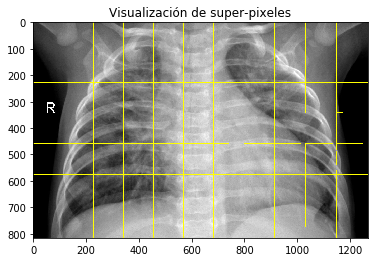

In [23]:
from skimage.segmentation import slic
from skimage import segmentation

img=Image.open('./chest_xray/test/PNEUMONIA/person147_bacteria_711.jpeg')

img_t=loader('./chest_xray/test/PNEUMONIA/person147_bacteria_711.jpeg')

slic_1=slic(transforms.ToPILImage()(img_t),n_segments=80)

slic = slic(img, n_segments=80)

plt.figure
plt.imshow(segmentation.mark_boundaries(img, slic))
plt.title('Visualización de super-pixeles')

plt.show()

In [48]:
img_t_copy=img_t.detach().numpy()

#Se modifica el metodo loader para que no lea imágenes desde una ruta, si no entregadas 
#ya como imágenes de python



C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


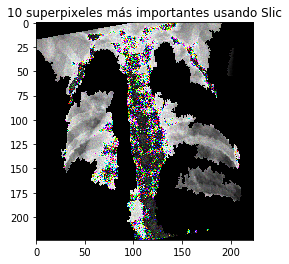

In [51]:
Lime(1000,slic_1,'Slic',net=0)